In [1]:
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pl.read_csv('../data/clean.csv')

In [12]:
with open('columns.txt','w') as f:
    for col in df.columns:
        print(col, file=f)

/tmp/ipykernel_579602/2362183069.py:3: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  .agg(pl.count().alias("count"))
/tmp/ipykernel_579602/2362183069.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_20, x="championName", y="count", palette="viridis")


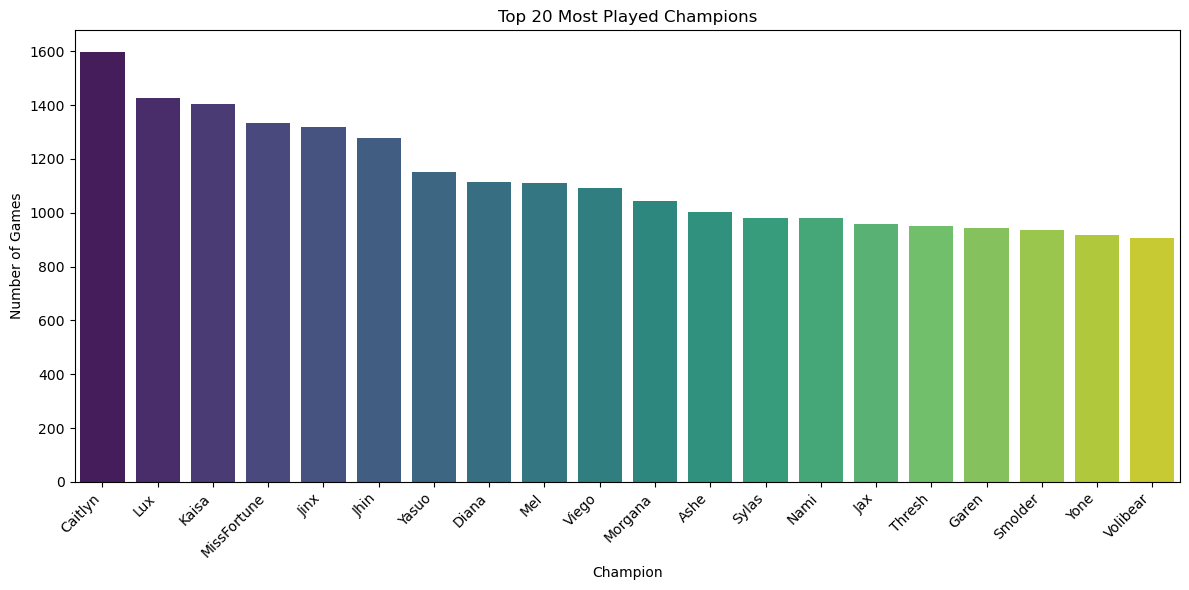

In [4]:
champion_distribution = (
    df.group_by("championName")
      .agg(pl.count().alias("count"))
      .sort("count", descending=True)
)


champion_distribution_pd = champion_distribution.to_pandas()


top_20 = champion_distribution_pd.head(20)

plt.figure(figsize=(12, 6))
sns.barplot(data=top_20, x="championName", y="count", palette="viridis")
plt.xticks(rotation=45, ha="right")
plt.title("Top 20 Most Played Champions")
plt.xlabel("Champion")
plt.ylabel("Number of Games")
plt.tight_layout()
plt.show()

we need to scale the data based on how many games we have with each champion

In [5]:
# Select only integer columns to aggregate
int_cols = [col for col in df.columns if df[col].dtype in (pl.Int32, pl.Int64)]

# Group and sum all integer columns per champion
aggregated = df.group_by("championName").agg([
    pl.col(col).sum().alias(col + "_sum") for col in int_cols
])
champion_counts = df.group_by("championName").agg(
    pl.count().alias("game_count")
)
champion_stats = aggregated.join(champion_counts, on="championName")
# Normalize each stat by game_count
normalized = champion_stats.with_columns([
    (pl.col(col) / pl.col("game_count")).alias(col.replace("_sum", "_avg"))
    for col in champion_stats.columns if col.endswith("_sum")
])


/tmp/ipykernel_579602/201063333.py:9: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  pl.count().alias("game_count")


In [6]:
normalized.head()

championName,PlayerScore0_sum,PlayerScore1_sum,PlayerScore10_sum,PlayerScore11_sum,PlayerScore2_sum,PlayerScore3_sum,PlayerScore4_sum,PlayerScore5_sum,PlayerScore6_sum,PlayerScore7_sum,PlayerScore8_sum,PlayerScore9_sum,allInPings_sum,assistMePings_sum,assists_sum,baronKills_sum,basicPings_sum,champExperience_sum,champLevel_sum,championId_sum,championTransform_sum,commandPings_sum,consumablesPurchased_sum,damageDealtToBuildings_sum,damageDealtToObjectives_sum,damageDealtToTurrets_sum,damageSelfMitigated_sum,dangerPings_sum,deaths_sum,detectorWardsPlaced_sum,doubleKills_sum,dragonKills_sum,enemyMissingPings_sum,enemyVisionPings_sum,getBackPings_sum,goldEarned_sum,…,summoner2Id_avg,summonerLevel_avg,teamId_avg,timeCCingOthers_avg,timePlayed_avg,totalAllyJungleMinionsKilled_avg,totalDamageDealt_avg,totalDamageDealtToChampions_avg,totalDamageShieldedOnTeammates_avg,totalDamageTaken_avg,totalEnemyJungleMinionsKilled_avg,totalHeal_avg,totalHealsOnTeammates_avg,totalMinionsKilled_avg,totalTimeCCDealt_avg,totalTimeSpentDead_avg,totalUnitsHealed_avg,tripleKills_avg,trueDamageDealt_avg,trueDamageDealtToChampions_avg,trueDamageTaken_avg,turretKills_avg,turretTakedowns_avg,turretsLost_avg,unrealKills_avg,visionClearedPings_avg,visionScore_avg,visionWardsBoughtInGame_avg,wardsKilled_avg,wardsPlaced_avg,gameCreation_avg,gameDuration_avg,gameEndTimestamp_avg,gameId_avg,gameStartTimestamp_avg,mapId_avg,queueId_avg
str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""Rumble""",0,0,0,0,0,0,0,0,0,0,0,0,104,532,1154,7,0,2705860,2636,11356,0,685,551,462195,1647037,462195,4631665,0,1119,156,82,41,880,510,290,2030201,…,8.958084,395.694611,158.083832,17.197605,1837.532934,10.568862,152925.952096,29160.08982,0.0,29431.077844,1.916168,4756.317365,0.0,168.850299,317.628743,226.443114,0.982036,0.071856,10225.023952,691.808383,1491.60479,1.023952,1.754491,6.05988,0.0,0.0,18.646707,1.041916,1.287425,9.095808,1.7571e12,1837.550898,1.7571e12,7.5235e9,1.7571e12,11.0,423.712575
"""Xerath""",0,0,0,0,0,0,0,0,0,0,0,0,181,1400,5739,11,0,8622838,8806,59893,0,2956,2292,1247987,3133306,1247987,4725787,0,3315,682,227,35,3341,1318,1075,6769958,…,8.514334,323.860034,150.252951,30.155143,1817.254637,0.311973,123317.56661,27614.210793,0.0,18291.726813,0.279933,2198.0,170.652614,134.593592,184.111298,175.021922,1.586847,0.03204,2690.89882,509.940978,925.715008,0.709949,1.605396,5.881956,0.0,0.0,31.089376,1.274874,2.451939,15.252951,1.7555e12,1817.268128,1.7555e12,7.5037e9,1.7555e12,11.0,423.237774
"""Briar""",0,0,0,0,0,0,0,0,0,0,0,0,488,2163,3918,142,0,7742252,7636,118830,0,2695,810,777805,14227591,777805,18753513,0,3700,380,379,734,1864,1415,1073,6602360,…,8.258824,313.366667,144.901961,29.990196,1762.841176,86.903922,229475.084314,24795.670588,0.0,42560.178431,10.519608,37791.02549,1.178431,37.594118,277.576471,229.835294,1.005882,0.084314,48885.860784,1695.894118,3223.15098,0.596078,1.217647,5.476471,0.0,0.0,18.227451,0.847059,1.915686,5.996078,1.7563e12,1762.85098,1.7563e12,7.4841e9,1.7563e12,11.0,423.176471
"""Zac""",0,0,0,0,0,0,0,0,0,0,0,0,195,1154,3383,66,0,4378027,4544,47278,0,1597,750,455496,5620753,455496,14476557,0,1662,387,104,346,1016,665,533,3472647,…,8.563518,335.76873,153.745928,44.045603,1777.980456,65.273616,177879.703583,19068.120521,5.319218,44703.885993,6.697068,49935.667752,169.006515,55.364821,433.508143,162.482085,2.859935,0.019544,48195.95114,1394.863192,5513.442997,0.605863,1.478827,5.990228,0.0,0.0,21.605863,1.429967,2.527687,7.127036,1.7557e12,1778.009772,1.7557e12,7.5062e9,1.7557e12,11.0,423.843648
"""Naafiri""",0,0,0,0,0,0,0,0,0,0,0,0,298,1181,2823,74,0,6054157,6153,387600,0,1996,933,930638,8087662,930638,9395632,0,2367,440,388,391,1874,815,836,5095775,…,8.696078,340.735294,150.735294,4.595588,1783.13

In [9]:
# most deaths
# Sort by average deaths descending
most_deaths = (
    normalized
    .sort("deaths_avg", descending=True)
    .select(["championName", "deaths_avg"])
    .head(10)
)

print(most_deaths)


shape: (10, 2)
┌──────────────┬────────────┐
│ championName ┆ deaths_avg │
│ ---          ┆ ---        │
│ str          ┆ f64        │
╞══════════════╪════════════╡
│ Karthus      ┆ 7.949367   │
│ Brand        ┆ 7.705882   │
│ Quinn        ┆ 7.667845   │
│ Pyke         ┆ 7.421687   │
│ Samira       ┆ 7.339483   │
│ KogMaw       ┆ 7.325      │
│ Briar        ┆ 7.254902   │
│ Kalista      ┆ 7.252033   │
│ Draven       ┆ 7.163399   │
│ Yasuo        ┆ 7.119896   │
└──────────────┴────────────┘


In [10]:
# Sort by average deaths ascending
fewest_deaths = (
    normalized
    .sort("deaths_avg", descending=False)
    .select(["championName", "deaths_avg"])
    .head(10)
)

print(fewest_deaths)


shape: (10, 2)
┌──────────────┬────────────┐
│ championName ┆ deaths_avg │
│ ---          ┆ ---        │
│ str          ┆ f64        │
╞══════════════╪════════════╡
│ Yuumi        ┆ 3.809019   │
│ Milio        ┆ 4.47427    │
│ Anivia       ┆ 4.904059   │
│ Janna        ┆ 4.95493    │
│ Ivern        ┆ 5.014388   │
│ Zilean       ┆ 5.048583   │
│ DrMundo      ┆ 5.066667   │
│ Nami         ┆ 5.213265   │
│ Ryze         ┆ 5.236923   │
│ Lulu         ┆ 5.25       │
└──────────────┴────────────┘


In [13]:
# Champion with highest average enemyMissingPings
most_missing_pings = (
    normalized
    .sort("enemyMissingPings_avg", descending=True)
    .select(["championName", "enemyMissingPings_avg"])
    .head(10)
)

print(most_missing_pings)


shape: (10, 2)
┌──────────────┬───────────────────────┐
│ championName ┆ enemyMissingPings_avg │
│ ---          ┆ ---                   │
│ str          ┆ f64                   │
╞══════════════╪═══════════════════════╡
│ Katarina     ┆ 7.01964               │
│ Syndra       ┆ 6.641256              │
│ Kassadin     ┆ 6.425532              │
│ Zed          ┆ 6.411215              │
│ Ahri         ┆ 6.390704              │
│ Ryze         ┆ 6.36                  │
│ Vex          ┆ 6.275281              │
│ Hwei         ┆ 6.02988               │
│ Fizz         ┆ 6.020877              │
│ Qiyana       ┆ 5.957055              │
└──────────────┴───────────────────────┘


In [14]:
win_rate_df = (
    df
    .group_by("championName")
    .agg([
        pl.col("win").sum().alias("wins"),
        pl.count().alias("games")
    ])
    .with_columns([
        (pl.col("wins") / pl.col("games")).alias("win_rate")
    ])
    .sort("win_rate", descending=True)
)

# Top champion by win rate
top_win_rate = win_rate_df.select(["championName", "win_rate"]).head(10)

print(top_win_rate)


shape: (10, 2)
┌──────────────┬──────────┐
│ championName ┆ win_rate │
│ ---          ┆ ---      │
│ str          ┆ f64      │
╞══════════════╪══════════╡
│ Anivia       ┆ 0.575646 │
│ Sona         ┆ 0.571906 │
│ Camille      ┆ 0.567568 │
│ Rell         ┆ 0.547368 │
│ Taliyah      ┆ 0.546185 │
│ Briar        ┆ 0.541176 │
│ Veigar       ┆ 0.539788 │
│ Belveth      ┆ 0.539267 │
│ Braum        ┆ 0.539095 │
│ Irelia       ┆ 0.537175 │
└──────────────┴──────────┘


/tmp/ipykernel_579602/152609981.py:6: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  pl.count().alias("games")


In [15]:
# Calculate win rate per champion
win_rate_df = (
    df
    .group_by("championName")
    .agg([
        pl.col("win").sum().alias("wins"),
        pl.len().alias("games")  # Use pl.len() instead of pl.count()
    ])
    .with_columns([
        (pl.col("wins") / pl.col("games")).alias("win_rate")
    ])
    .sort("win_rate", descending=False)  # Sort ascending for lowest win rate
)

# Select bottom 10 champions
lowest_win_rate = win_rate_df.select(["championName", "win_rate"]).head(10)

print(lowest_win_rate)


shape: (10, 2)
┌──────────────┬──────────┐
│ championName ┆ win_rate │
│ ---          ┆ ---      │
│ str          ┆ f64      │
╞══════════════╪══════════╡
│ KSante       ┆ 0.421053 │
│ Neeko        ┆ 0.429561 │
│ Kalista      ┆ 0.430894 │
│ Akali        ┆ 0.435967 │
│ Ezreal       ┆ 0.439159 │
│ Riven        ┆ 0.450331 │
│ Yunara       ┆ 0.451895 │
│ Qiyana       ┆ 0.456033 │
│ Olaf         ┆ 0.456522 │
│ Orianna      ┆ 0.458252 │
└──────────────┴──────────┘


In [16]:
# Champion with highest average magic damage to champions
highest_magic_dmg = (
    normalized
    .sort("magicDamageDealtToChampions_avg", descending=True)
    .select(["championName", "magicDamageDealtToChampions_avg"])
    .head(10)
)

print(highest_magic_dmg)


shape: (10, 2)
┌──────────────┬─────────────────────────────────┐
│ championName ┆ magicDamageDealtToChampions_av… │
│ ---          ┆ ---                             │
│ str          ┆ f64                             │
╞══════════════╪═════════════════════════════════╡
│ Karthus      ┆ 34639.443038                    │
│ Heimerdinger ┆ 30546.738007                    │
│ Ziggs        ┆ 28816.738318                    │
│ Rumble       ┆ 27180.784431                    │
│ Xerath       ┆ 26416.951096                    │
│ Hwei         ┆ 26263.88247                     │
│ Vladimir     ┆ 26080.371542                    │
│ Viktor       ┆ 26065.342857                    │
│ Brand        ┆ 25443.70778                     │
│ Veigar       ┆ 24916.198939                    │
└──────────────┴─────────────────────────────────┘


In [17]:
# Champion with highest average physical damage to champions
highest_physical_dmg = (
    normalized
    .sort("physicalDamageDealtToChampions_avg", descending=True)
    .select(["championName", "physicalDamageDealtToChampions_avg"])
    .head(5)
)

print(highest_physical_dmg)


shape: (5, 2)
┌──────────────┬─────────────────────────────────┐
│ championName ┆ physicalDamageDealtToChampions… │
│ ---          ┆ ---                             │
│ str          ┆ f64                             │
╞══════════════╪═════════════════════════════════╡
│ Illaoi       ┆ 26831.968421                    │
│ Draven       ┆ 25801.24183                     │
│ Sivir        ┆ 25172.053601                    │
│ Xayah        ┆ 24473.399516                    │
│ Quinn        ┆ 24342.060071                    │
└──────────────┴─────────────────────────────────┘


In [19]:
# Champion with highest average self-mitigated damage
highest_self_mitigated = (
    normalized
    .sort("damageSelfMitigated_avg", descending=True)
    .select(["championName", "damageSelfMitigated_avg"])
    .head(5)
)

print(highest_self_mitigated)


shape: (5, 2)
┌──────────────┬─────────────────────────┐
│ championName ┆ damageSelfMitigated_avg │
│ ---          ┆ ---                     │
│ str          ┆ f64                     │
╞══════════════╪═════════════════════════╡
│ Sion         ┆ 76733.720065            │
│ Skarner      ┆ 67355.27957             │
│ Rammus       ┆ 66599.837349            │
│ Sejuani      ┆ 57991.463768            │
│ KSante       ┆ 53074.575439            │
└──────────────┴─────────────────────────┘


In [23]:
first_blood_rate = (
    df
    .group_by("championName")
    .agg([
        pl.col("firstBloodKill").cast(pl.Int32).sum().alias("firstBloodKills"),
        pl.len().alias("games")
    ])
    .with_columns([
        (pl.col("firstBloodKills") / pl.col("games")).alias("firstBloodKill_rate")
    ])
    .sort("firstBloodKill_rate", descending=True)
)

top_first_blood = first_blood_rate.select(["championName", "firstBloodKill_rate"]).head(5)

print(top_first_blood)


shape: (5, 2)
┌──────────────┬─────────────────────┐
│ championName ┆ firstBloodKill_rate │
│ ---          ┆ ---                 │
│ str          ┆ f64                 │
╞══════════════╪═════════════════════╡
│ Kalista      ┆ 0.268293            │
│ Kled         ┆ 0.216561            │
│ Irelia       ┆ 0.210037            │
│ Sett         ┆ 0.202059            │
│ Twitch       ┆ 0.189236            │
└──────────────┴─────────────────────┘


In [25]:
# Champion with highest average assists
most_assists = (
    normalized
    .sort("assists_avg", descending=True)
    .select(["championName", "assists_avg"])
    .head(5)
)

print(most_assists)


shape: (5, 2)
┌──────────────┬─────────────┐
│ championName ┆ assists_avg │
│ ---          ┆ ---         │
│ str          ┆ f64         │
╞══════════════╪═════════════╡
│ Rell         ┆ 16.802632   │
│ Yuumi        ┆ 16.477454   │
│ Braum        ┆ 15.95679    │
│ Rakan        ┆ 15.894472   │
│ Nami         ┆ 15.729592   │
└──────────────┴─────────────┘


In [27]:
# Champion with highest average wards placed
most_wards_placed = (
    normalized
    .sort("wardsPlaced_avg", descending=True)
    .select(["championName", "wardsPlaced_avg"])
    .head(5)
)

print(most_wards_placed)


shape: (5, 2)
┌──────────────┬─────────────────┐
│ championName ┆ wardsPlaced_avg │
│ ---          ┆ ---             │
│ str          ┆ f64             │
╞══════════════╪═════════════════╡
│ Rakan        ┆ 27.11809        │
│ Janna        ┆ 26.492958       │
│ Alistar      ┆ 26.286458       │
│ Bard         ┆ 26.221766       │
│ Rell         ┆ 25.7            │
└──────────────┴─────────────────┘


In [29]:
# Champion with highest average pentakills
most_pentakills = (
    normalized
    .sort("pentaKills_avg", descending=True)
    .select(["championName", "pentaKills_avg"])
    .head(5)
)

print(most_pentakills)


shape: (5, 2)
┌──────────────┬────────────────┐
│ championName ┆ pentaKills_avg │
│ ---          ┆ ---            │
│ str          ┆ f64            │
╞══════════════╪════════════════╡
│ Samira       ┆ 0.01476        │
│ Katarina     ┆ 0.013093       │
│ MasterYi     ┆ 0.012129       │
│ Hecarim      ┆ 0.010067       │
│ Kalista      ┆ 0.00813        │
└──────────────┴────────────────┘


In [31]:
# Champion with highest average objectives stolen
most_objectives_stolen = (
    normalized
    .sort("objectivesStolen_avg", descending=True)
    .select(["championName", "objectivesStolen_avg"])
    .head(5)
)

print(most_objectives_stolen)


shape: (5, 2)
┌──────────────┬──────────────────────┐
│ championName ┆ objectivesStolen_avg │
│ ---          ┆ ---                  │
│ str          ┆ f64                  │
╞══════════════╪══════════════════════╡
│ Khazix       ┆ 0.148014             │
│ JarvanIV     ┆ 0.120061             │
│ Kayn         ┆ 0.119504             │
│ LeeSin       ┆ 0.11449              │
│ Ekko         ┆ 0.112299             │
└──────────────┴──────────────────────┘


In [33]:
# Champion with highest average gold earned
most_gold_earned = (
    normalized
    .sort("goldEarned_avg", descending=True)
    .select(["championName", "goldEarned_avg"])
    .head(5)
)

print(most_gold_earned)


shape: (5, 2)
┌──────────────┬────────────────┐
│ championName ┆ goldEarned_avg │
│ ---          ┆ ---            │
│ str          ┆ f64            │
╞══════════════╪════════════════╡
│ Gangplank    ┆ 13921.796992   │
│ Karthus      ┆ 13762.71519    │
│ Draven       ┆ 13659.958606   │
│ Zeri         ┆ 13531.077236   │
│ Graves       ┆ 13180.884868   │
└──────────────┴────────────────┘


In [35]:
# Champion with lowest average gold earned
least_gold_earned = (
    normalized
    .sort("goldEarned_avg", descending=False)
    .select(["championName", "goldEarned_avg"])
    .head(5)
)

print(least_gold_earned)


shape: (5, 2)
┌──────────────┬────────────────┐
│ championName ┆ goldEarned_avg │
│ ---          ┆ ---            │
│ str          ┆ f64            │
╞══════════════╪════════════════╡
│ Janna        ┆ 7893.56338     │
│ Soraka       ┆ 7935.762004    │
│ Yuumi        ┆ 7957.450928    │
│ Milio        ┆ 7992.40751     │
│ Lulu         ┆ 8167.765537    │
└──────────────┴────────────────┘


In [36]:
# Champion with highest average heals on teammates
most_team_healing = (
    normalized
    .sort("totalHealsOnTeammates_avg", descending=True)
    .select(["championName", "totalHealsOnTeammates_avg"])
    .head(5)
)

print(most_team_healing)


shape: (5, 2)
┌──────────────┬───────────────────────────┐
│ championName ┆ totalHealsOnTeammates_avg │
│ ---          ┆ ---                       │
│ str          ┆ f64                       │
╞══════════════╪═══════════════════════════╡
│ Soraka       ┆ 21696.359081              │
│ Nami         ┆ 9754.583673               │
│ Sona         ┆ 9535.816054               │
│ Milio        ┆ 7644.121001               │
│ Yuumi        ┆ 7535.732095               │
└──────────────┴───────────────────────────┘


In [38]:
# Champion with highest average time CCing others
most_cc_time = (
    normalized
    .sort("timeCCingOthers_avg", descending=True)
    .select(["championName", "timeCCingOthers_avg"])
    .head(5)
)

print(most_cc_time)


shape: (5, 2)
┌──────────────┬─────────────────────┐
│ championName ┆ timeCCingOthers_avg │
│ ---          ┆ ---                 │
│ str          ┆ f64                 │
╞══════════════╪═════════════════════╡
│ Nocturne     ┆ 164.303371          │
│ Chogath      ┆ 78.162476           │
│ Maokai       ┆ 66.333333           │
│ Nautilus     ┆ 65.28               │
│ Morgana      ┆ 58.08134            │
└──────────────┴─────────────────────┘


In [40]:
# Filter for games that were lost and ended in surrender
surrender_losses = df.filter(
    (pl.col("win") == 0) & (pl.col("gameEndedInSurrender") == True)
)

# Count surrender losses per champion
surrender_loss_counts = (
    surrender_losses
    .group_by("championName")
    .agg([
        pl.len().alias("surrender_losses")
    ])
    .sort("surrender_losses", descending=True)
)

# Top champion(s)
top_surrender_loser = surrender_loss_counts.head(5)

print(top_surrender_loser)


shape: (5, 2)
┌──────────────┬──────────────────┐
│ championName ┆ surrender_losses │
│ ---          ┆ ---              │
│ str          ┆ u32              │
╞══════════════╪══════════════════╡
│ Caitlyn      ┆ 185              │
│ Kaisa        ┆ 173              │
│ Jinx         ┆ 167              │
│ MissFortune  ┆ 163              │
│ Jhin         ┆ 149              │
└──────────────┴──────────────────┘
